## Download data

At first we are going to download train dataset using kaggle API

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ruslanshudra","key":"e31748dd2409e6504f0be0127f5f976e"}'}

In [ ]:
!pip install kaggle

In [ ]:
import os

# Set up Kaggle API key
kaggle_key_path = '/content/kaggle.json'
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
if not os.path.exists(kaggle_key_path):
    raise FileNotFoundError("Upload the Kaggle API key file first.")

# Set appropriate permissions for the Kaggle API key file
os.chmod(kaggle_key_path, 600)

# Download the dataset
dataset_name = "airbus-ship-detection"  # Replace with the actual dataset name or URL

# Adjust the download command to include the dataset name and destination folder
download_command = f'kaggle competitions download -c airbus-ship-detection -p /content'
!{download_command}

100% 28.6G/28.6G [03:45<00:00, 62.7MB/s]
100% 28.6G/28.6G [03:45<00:00, 136MB/s] 


In [ ]:
!unzip airbus-ship-detection.zip

## Data Preprocessing

Now let`s look at our data

In [ ]:
! pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 5.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import save_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [ ]:
df = pd.read_csv('/content/train_ship_segmentations_v2.csv')
df = df.drop_duplicates()

In [ ]:
display(df.head(10))

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


We can see that on some of the pictures there are no boats (NaN target value) and some pictures can have multiple boats. We have to consider it when solving the task.    
Let's change our dataset - for each image create a list of encoded pixels and create a column that will indicate if there is a ship on the image.

In [ ]:
# Function to create new dataset with pixels list and dummy variable 'has_ship'
def process_image_data(df):
    # Group by imageId and aggregate the encoded pixels into a list
    grouped_df = df.groupby('ImageId')['EncodedPixels'].agg(lambda x: [v for v in x if pd.notna(v)]).reset_index()

    # Replace [nan] with an empty list
    grouped_df['EncodedPixels'] = grouped_df['EncodedPixels'].apply(lambda x: [] if x == [np.nan] else x)

    # Create a new column 'has_ship' based on NaN values in 'encodedPixels'
    grouped_df['has_ship'] = grouped_df['EncodedPixels'].apply(lambda x: 0 if not x else 1)

    return grouped_df

In [ ]:
image_data = process_image_data(df)

In [ ]:
display(image_data)

,ImageId,EncodedPixels,has_ship
0,00003e153.jpg,[],0
1,0001124c7.jpg,[],0
2,000155de5.jpg,[264661 17 265429 33 266197 33 266965 33 26773...,1
3,000194a2d.jpg,[360486 1 361252 4 362019 5 362785 8 363552 10...,1
4,0001b1832.jpg,[],0
...,...,...,...
192551,fffedbb6b.jpg,[],0
192552,ffff2aa57.jpg,[],0
192553,ffff6e525.jpg,[],0
192554,ffffc50b4.jpg,[],0


In [ ]:
display(image_data[image_data['ImageId'] == '000194a2d.jpg'])

,ImageId,EncodedPixels,has_ship
3,000194a2d.jpg,[360486 1 361252 4 362019 5 362785 8 363552 10...,1


In [ ]:
# Function to decode pixels
def decode_pixels(encoded_pixels_list, img_size=(768, 768)):
    masks = []
    for encoded_pixels in encoded_pixels_list:
        if encoded_pixels:
            pairs = list(map(int, encoded_pixels.split()))
            mask = np.zeros(img_size[0] * img_size[1])
            for i in range(0, len(pairs), 2):
                start = pairs[i] - 1
                length = pairs[i + 1]
                mask[start:start + length] = 1
            masks.append(mask.reshape(img_size[0], img_size[1]))
    return masks

# Function to get segmentation mask
def get_mask(encoded_pixels_list, img_size=(768, 768)):
    masks = []
    for encoded_pixels in encoded_pixels_list:
        if encoded_pixels:
            pairs = list(map(int, encoded_pixels.split()))
            mask = np.zeros(img_size[0] * img_size[1])
            for i in range(0, len(pairs), 2):
                start = pairs[i] - 1
                length = pairs[i + 1]
                mask[start:start + length] = 1
            masks.append(mask.reshape(img_size[0], img_size[1]))

    binary_mask = np.zeros_like(masks[0])

    # Combine individual masks into a binary mask
    for mask in masks:
        binary_mask = np.logical_or(binary_mask, mask)

    # Create a grayscale mask directly
    gray_mask = binary_mask.astype(np.uint8) * 255
    # We also have to transpose mask to match the original image
    gray_mask  = gray_mask.reshape(img_size).T
    return gray_mask

Let's take a look at random picture

In [ ]:
image_id = '000194a2d.jpg'

img = cv2.imread('/content/train_v2/{}'.format(image_id))

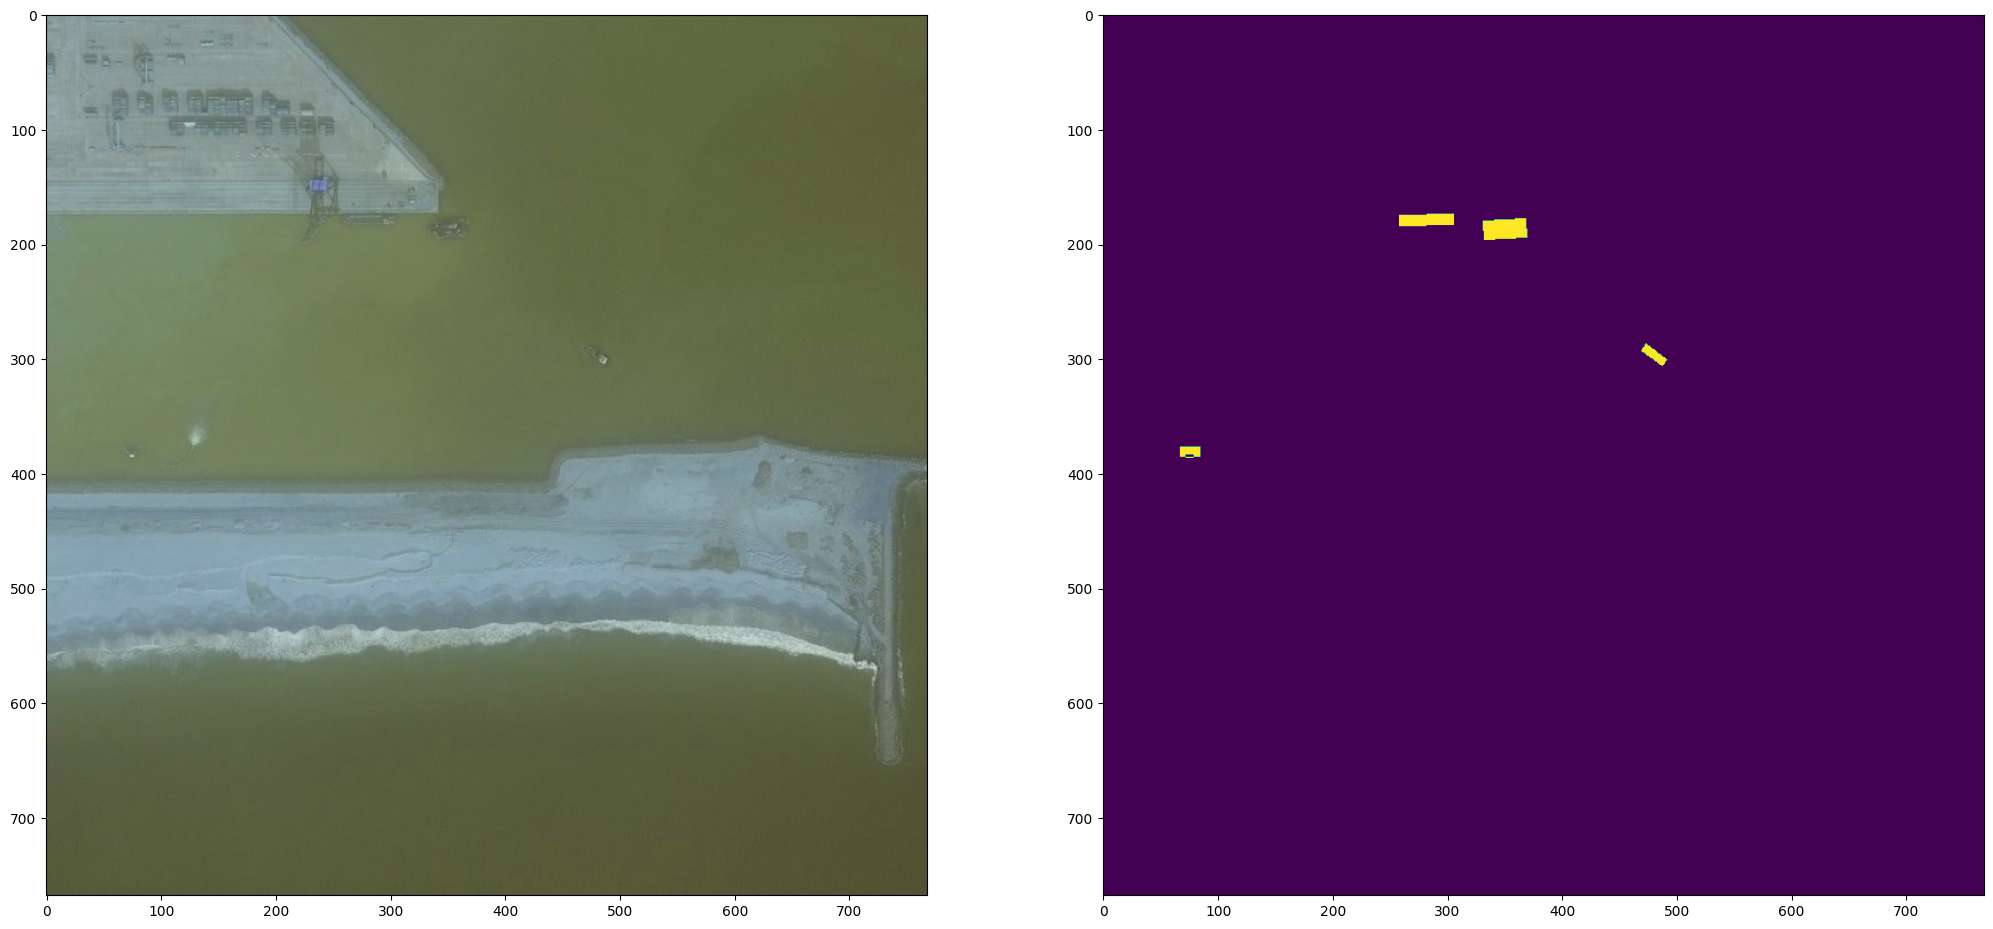

In [ ]:
encoded_pixels = image_data[image_data['ImageId'] == image_id]['EncodedPixels'].iloc[0]
mask = get_mask(encoded_pixels)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(img)
axes[1].imshow(mask)

plt.show()

Now we can perform our task - we will split it into 2 parts - firstly we will detect if the ship is at the image. Then we will train NN with encoder-decoder architecture to perform segmentation task.

## Detecting ship existance

Before training the classification model we have to check class imbalance and balance our data.

In [ ]:
# Count the number of instances for each class
class_counts = image_data['has_ship'].value_counts()

# Print the counts and ratio
print("Number of has_ship=0:", class_counts[0])
print("Number of has_ship=1:", class_counts[1])

# Calculate the ratio
imbalance_ratio = class_counts[0] / class_counts[1]
print("Class Imbalance Ratio:", imbalance_ratio)

Number of has_ship=0: 150000
Number of has_ship=1: 42556
Class Imbalance Ratio: 3.5247673653538865


In [ ]:
# Separate the majority and minority classes
majority_class = image_data[image_data['has_ship'] == 0]
minority_class = image_data[image_data['has_ship'] == 1]

# Downsample the majority class to balance the classes
downsampled_majority_class = resample(
    majority_class,
    replace=False,
    n_samples=len(minority_class),
    random_state=42
)

# Concatenate the downsampled majority class with the minority class
balanced_data = pd.concat([downsampled_majority_class, minority_class])


balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

Let's train a model that will detect existanse of the ship on the image.     
Firstly, let's create a generator function that will extract some number of images and put it into the model.

In [ ]:
# Generator to get some subset of the train set
def keras_generator_classif(gen_df, batch_size, shape = (768, 768)):
    while True:
        x_batch = []
        y_batch = []

        for i in range(batch_size):
            img_name, has_ship = gen_df.sample(1).values[0]
            img = cv2.imread('/content/train_v2/{}'.format(img_name))

            img = cv2.resize(img, (shape[0], shape[1]))

            x_batch += [img]
            y_batch += [has_ship]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, y_batch

Let's create classification model.

In [ ]:
img_shape = (224, 224, 3)
# Load MobileNetV2 as the base model
base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Create the model by adding custom layers on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Model compilation
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(balanced_data, test_size=0.2, random_state=42)

# Create generator instances
batch_size = 100
train_generator = keras_generator_classif(train_df[['ImageId', 'has_ship']], batch_size, img_shape)
validation_generator = keras_generator_classif(val_df[['ImageId', 'has_ship']], batch_size, img_shape)

In [ ]:
# Use the generator for training and validation
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    verbose=1,
    epochs=8,
    validation_data=validation_generator,
    validation_steps=20,
)

Epoch 1/8
50/50 [==============================] - 491s 10s/step - loss: 0.5609 - binary_accuracy: 0.7094 - precision: 0.7106 - recall: 0.6966 - auc: 0.7812 - val_loss: 0.3861 - val_binary_accuracy: 0.8380 - val_precision: 0.9206 - val_recall: 0.7443 - val_auc: 0.9121
Epoch 2/8
50/50 [==============================] - 549s 11s/step - loss: 0.4019 - binary_accuracy: 0.8328 - precision: 0.8840 - recall: 0.7542 - auc: 0.8878 - val_loss: 0.3235 - val_binary_accuracy: 0.8680 - val_precision: 0.9070 - val_recall: 0.8250 - val_auc: 0.9432
Epoch 3/8
50/50 [==============================] - 466s 9s/step - loss: 0.3728 - binary_accuracy: 0.8444 - precision: 0.8871 - recall: 0.7881 - auc: 0.9069 - val_loss: 0.2963 - val_binary_accuracy: 0.8725 - val_precision: 0.9291 - val_recall: 0.8080 - val_auc: 0.9505
Epoch 4/8
50/50 [==============================] - 477s 10s/step - loss: 0.3374 - binary_accuracy: 0.8612 - precision: 0.8992 - recall: 0.8233 - auc: 0.9271 - val_loss: 0.2663 - val_binary_accur

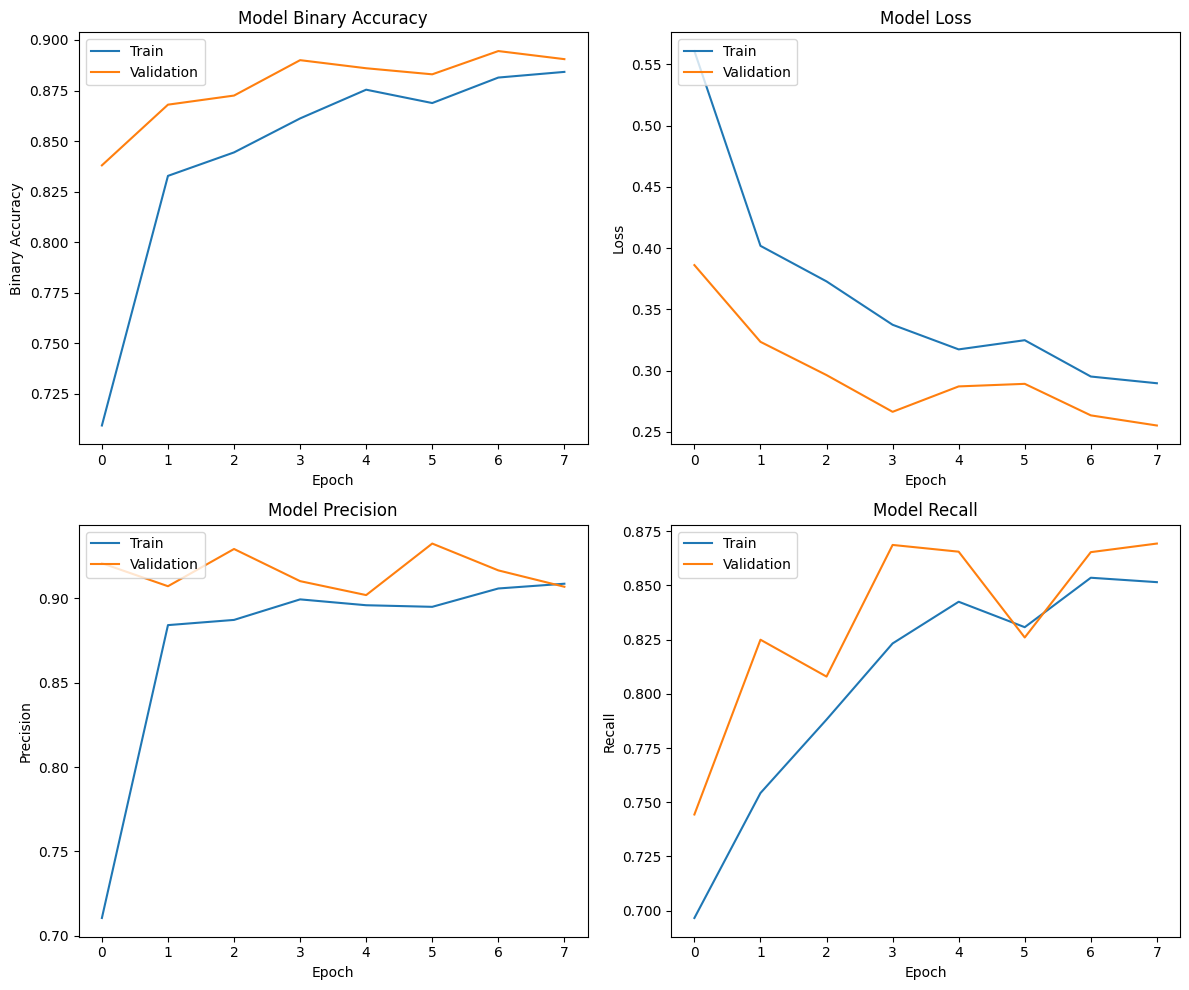

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 10))

    # Plot training & validation accuracy values
    plt.subplot(2, 2, 1)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model Binary Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation Precision values
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('Model Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation Recall values
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Model Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_history(history)

In [ ]:
model.save('classif_model.h5')

## Segmentation model

Firstly, let's create another generator function suitable for segmentation task.

In [ ]:
# Another generator for segmentation task
def keras_generator_segment(gen_df, batch_size, shape = (768, 768)):
    while True:
        x_batch = []
        y_batch = []

        for i in range(batch_size):
            img_name, encoded_pixs = gen_df.sample(1).values[0]
            img = cv2.imread('/content/train_v2/{}'.format(img_name))
            encoded_pixels = gen_df[gen_df['ImageId'] == img_name]['EncodedPixels'].iloc[0]
            mask = get_mask(encoded_pixels)

            img = cv2.resize(img, (shape[0],shape[1]))
            mask = cv2.resize(mask, (shape[0],shape[1]))


            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch) / 255

        yield x_batch, np.expand_dims(y_batch, -1)

Now let\`s create model. We will not use base U-net model architecture to solve segmentation task because we have lack of RAM. We will implement simple encoder-decoder architecture instead.

In [ ]:
# Define the DiceLoss class
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1 - tf.divide(nominator, denominator)
        return result

# Define the Intersection over Union (IoU) metric
def iou_metric(y_true, y_pred):
    intersection = tf.reduce_sum(tf.minimum(y_true, y_pred))
    union = tf.reduce_sum(tf.maximum(y_true, y_pred))
    iou = intersection / union
    return iou

In [ ]:
def create_segment_model(input_shape=(256, 256, 3), num_channels=1):
    # Input layer
    input_layer = tf.keras.Input(shape=(input_shape[0], input_shape[1], 3), dtype=tf.float32)

    # Convolutional block 1
    conv1 = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(2, 2),
        strides=(1, 1),
        padding='same',
        kernel_initializer=tf.keras.initializers.HeNormal(),
        activation='relu',
        dtype=tf.float32
    )(input_layer)
    pool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv1)

    # Convolutional block 2
    conv2 = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(2, 2),
        strides=(1, 1),
        padding='same',
        kernel_initializer=tf.keras.initializers.HeNormal(),
        activation='relu',
        dtype=tf.float32
    )(pool1)
    pool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv2)

    # Convolutional block 3
    conv3 = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(2, 2),
        strides=(1, 1),
        padding='same',
        kernel_initializer=tf.keras.initializers.HeNormal(),
        activation='relu',
        dtype=tf.float32
    )(pool2)

    # Transposed convolution block 1
    transp_conv1 = tf.keras.layers.Conv2DTranspose(
        filters=128,
        kernel_size=(2, 2),
        strides=(1, 1),
        padding='same',
        kernel_initializer=tf.keras.initializers.HeNormal(),
        activation='relu',
        dtype=tf.float32
    )(conv3)
    upsample_1 = tf.keras.layers.UpSampling2D(size=(2, 2))(transp_conv1)

    # Transposed convolution block 2
    transp_conv2 = tf.keras.layers.Conv2DTranspose(
        filters=64,
        kernel_size=(2, 2),
        strides=(1, 1),
        padding='same',
        kernel_initializer=tf.keras.initializers.HeNormal(),
        activation='relu',
        dtype=tf.float32
    )(upsample_1)
    upsample_2 = tf.keras.layers.UpSampling2D(size=(2, 2))(transp_conv2)

    # Transposed convolution block 3
    transp_conv3 = tf.keras.layers.Conv2DTranspose(
        filters=32,
        kernel_size=(2, 2),
        strides=(1, 1),
        padding='same',
        kernel_initializer=tf.keras.initializers.HeNormal(),
        activation='relu',
        dtype=tf.float32
    )(upsample_2)

    # Output layer
    outputs = tf.keras.layers.Conv2D(num_channels, 1, activation='sigmoid', dtype=tf.float32)(transp_conv3)

    # Create model
    model = tf.keras.models.Model(inputs=input_layer, outputs=outputs)

    # Define Dice Loss and IoU metric
    dice_loss = DiceLoss()
    iou_metric_value = iou_metric

    # Compile the model with Dice Loss and IoU metric
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
                  loss=dice_loss,
                  metrics=[iou_metric_value])

    return model

# Create segmentation model
segm_model = create_segment_model()


In [ ]:
segm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       32896 

At least let\`s provide training of our model

In [ ]:
img_shape = (256, 256, 3)
# Split the data into training and validation sets
train_df, val_df = train_test_split(minority_class, test_size=0.2, random_state=42)

# Create generator instances
batch_size = 30

train_generator = keras_generator_segment(train_df[['ImageId', 'EncodedPixels']], batch_size, img_shape)
validation_generator = keras_generator_segment(val_df[['ImageId', 'EncodedPixels']], batch_size, img_shape)

In [ ]:
# Garbage Collector
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

callbacks = [
    GarbageCollectorCallback(),
    ModelCheckpoint(filepath='model_weights.h5', save_best_only=True, save_weights_only=True)
]

In [ ]:
# Delete some unnecessary variables to free RAM
del image_data
del majority_class
del df
del downsampled_majority_class
del balanced_data

In [ ]:
gc.collect()

33523

As we have lack of RAM we will save best weights and restart traing several times to achive appropriate accuracy.

In [ ]:
segm_model.load_weights('model_weights.h5')

In [ ]:
segm_model.fit(
    train_generator,
    steps_per_epoch=20,
    epochs=3,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=10,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True,
    shuffle=True,
    callbacks=callbacks
)

Epoch 1/3
20/20 [==============================] - 407s 20s/step - loss: 0.5352 - iou_metric: 0.1540 - val_loss: 0.4855 - val_iou_metric: 0.2063
Epoch 2/3
20/20 [==============================] - 373s 19s/step - loss: 0.5058 - iou_metric: 0.1768 - val_loss: 0.4759 - val_iou_metric: 0.1734
Epoch 3/3
20/20 [==============================] - 357s 18s/step - loss: 0.5259 - iou_metric: 0.1616 - val_loss: 0.5219 - val_iou_metric: 0.2186


In [ ]:
segm_model.save('segm_model.h5')

Now we can use our trained models to perform segmentation tasks.